In [37]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from lifetimes.utils import summary_data_from_transaction_data
import seaborn as sns
from lifetimes.utils import calibration_and_holdout_data
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from lifetimes import BetaGeoFitter, GammaGammaFitter
import warnings


warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [38]:
clean_transaction_log = pd.read_csv("../dataset/clear_transaction_log.csv")
customers_df = pd.read_csv('../dataset/customers.csv')
customers_df

,visitorid,Recency,View_Count,Cart_Count,Frequency,Monetary,Conversion_Rate
0,172,35,33,3,2,99600.0,0.054054
1,186,37,2,1,1,59880.0,0.250000
2,264,11,3,2,2,94056.0,0.333333
3,419,51,4,1,1,17160.0,0.166667
4,539,94,4,2,1,34920.0,0.142857
...,...,...,...,...,...,...,...
11714,1406787,108,20,0,1,54000.0,0.047619
11715,1406981,123,4,1,1,143880.0,0.166667
11716,1407070,127,1,3,1,79080.0,0.200000
11717,1407110,45,7,1,1,20400.0,0.111111


In [39]:
clean_transaction_log

,visitorid,date,transactionid,monetary_value
0,869008,2015-05-03 03:27:21.391,9765.0,19800.000000
1,345781,2015-05-03 03:35:01.772,1016.0,158799.081775
2,586756,2015-05-03 04:01:47.591,10942.0,30600.000000
3,435495,2015-05-03 04:07:38.961,6173.0,9960.000000
4,266417,2015-05-03 04:31:14.903,12546.0,5040.000000
...,...,...,...,...
22452,152963,2015-09-18 02:08:16.512,5772.0,15840.000000
22453,152963,2015-09-18 02:08:16.512,5772.0,16080.000000
22454,152963,2015-09-18 02:08:16.528,5772.0,194880.000000
22455,152963,2015-09-18 02:38:18.098,5670.0,34800.000000


In [40]:
# Group by visitorid and date (datetime), sum the monetary_value for each customer per day
clean_transaction_log_grouped = clean_transaction_log.copy()
clean_transaction_log_grouped['date'] = pd.to_datetime(clean_transaction_log_grouped['date'])

# Extract date part in a new column to avoid KeyError
clean_transaction_log_grouped['date_only'] = clean_transaction_log_grouped['date'].dt.date

# Group by visitorid and date_only (at daily level), sum monetary_value
grouped = (
    clean_transaction_log_grouped
    .groupby(['visitorid', 'date_only'], as_index=False)
    .agg({'monetary_value': 'sum'})
    .rename(columns={'date_only': 'date'})
)

# Convert 'date' to string in yyyy-mm-dd format
grouped['date'] = grouped['date'].astype(str)

grouped


,visitorid,date,monetary_value
0,172,2015-08-15,99600.0
1,186,2015-08-12,59880.0
2,264,2015-09-07,94056.0
3,419,2015-07-29,17160.0
4,539,2015-06-16,34920.0
...,...,...,...
13208,1406787,2015-06-01,54000.0
13209,1406981,2015-05-18,143880.0
13210,1407070,2015-05-13,79080.0
13211,1407110,2015-08-04,20400.0


In [41]:
grouped['visitorid'].value_counts()

visitorid
1150086    63
530559     53
138131     37
899857     34
152963     30
           ..
1404086     1
1404130     1
1404233     1
1404265     1
1407398     1
Name: count, Length: 11719, dtype: int64

In [42]:
# To get the visitorid(s) with exactly k transactions:
k = 3  # change this to the desired number of transactions
visitor_ids_with_k_transactions = grouped['visitorid'].value_counts()
visitor_ids_with_k_transactions = visitor_ids_with_k_transactions[visitor_ids_with_k_transactions == k].index.tolist()
print(f"Visitor IDs with exactly {k} transactions:", visitor_ids_with_k_transactions)

Visitor IDs with exactly 3 transactions: [154970, 817474, 819547, 262357, 829289, 170470, 841939, 248679, 875921, 101175, 761783, 219788, 516732, 163049, 962631, 964794, 986577, 988939, 998017, 323687, 958461, 1031046, 146698, 710338, 536804, 521563, 792741, 347610, 1076366, 1082305, 610841, 1023195, 1112013, 1113351, 625795, 1117293, 1122870, 1124964, 240998, 509346, 677299, 537639, 475479, 455557, 1040857, 1172087, 1185234, 1205233, 1210136, 468466, 1246823, 1255456, 1260481, 706387, 381345, 660393, 346597, 79721, 748562, 243025, 407882, 1374597, 1378697, 1379388, 808813, 1169956]


In [43]:
grouped[grouped['visitorid'] == 1404894]

,visitorid,date,monetary_value
13198,1404894,2015-09-08,43800.0


In [44]:
clv_data = summary_data_from_transaction_data(
    grouped,
    'visitorid',
    'date',
    monetary_value_col='monetary_value',
    observation_period_end='2015-09-18', # Ngày cuối cùng trong dataset RetailRocket
    include_first_transaction=False
)

print(f"Dữ liệu summary có {len(clv_data)} khách hàng.")
clv_data.tail(15)

Dữ liệu summary có 11719 khách hàng.


,frequency,recency,T,monetary_value
visitorid,,,,
1404894,0.0,0.0,10.0,0.0
1404991,0.0,0.0,88.0,0.0
1405688,0.0,0.0,93.0,0.0
1405714,0.0,0.0,125.0,0.0
1405831,0.0,0.0,77.0,0.0
1405861,0.0,0.0,121.0,0.0
1405929,0.0,0.0,15.0,0.0
1406087,0.0,0.0,108.0,0.0
1406564,0.0,0.0,23.0,0.0


In [45]:
clv_data.loc[[1404894]]

,frequency,recency,T,monetary_value
visitorid,,,,
1404894,0.0,0.0,10.0,0.0


In [46]:
# Filter customers who purchased more than once to calculate the time between purchases
repeat_customers = clv_data[clv_data['frequency'] > 0]

# Estimate the average time between purchases (unit: days)
avg_days_between_purchases = (repeat_customers['recency'] / repeat_customers['frequency']).mean()
median_days_between_purchases = (repeat_customers['recency'] / repeat_customers['frequency']).median()

print(f"Average number of days between two purchases: {avg_days_between_purchases:.1f} days")
print(f"Median number of days between two purchases: {median_days_between_purchases:.1f} days")


Average number of days between two purchases: 14.1 days
Median number of days between two purchases: 5.7 days


### BG/NBD: Beta Geometric / Negative Binomial Distribution
Mô hình thống kê dùng để dự đoán hành vi mua lặp lại của khách hàng trong tương lai

In [47]:
# print("--- START PENALIZER_COEF OPTIMIZATION ---")

# # 1. Split data: use the last 30 days as holdout
# # Your data ends on 2015-09-18
# observation_end = '2015-09-18'
# calibration_end = '2015-08-18'  # Move back 1 month to create the training set

# summary_cal_holdout = calibration_and_holdout_data(
#     grouped, 
#     'visitorid', 
#     'date', 
#     calibration_period_end=calibration_end,
#     observation_period_end=observation_end
# ) #Hàm trả về 1 DataFrame, mỗi dòng là 1 khách hàng


In [48]:
# summary_cal_holdout

In [49]:
# l2_params = [0.0005, 0.001, 0.01, 0.05, 0.1, 0.2]
# results = []

# print(f"Testing on {len(summary_cal_holdout)} customers...")

# for coef in l2_params:
#     # Train model
#     bgf_test = BetaGeoFitter(penalizer_coef=coef)
#     bgf_test.fit(
#         summary_cal_holdout['frequency_cal'], 
#         summary_cal_holdout['recency_cal'], 
#         summary_cal_holdout['T_cal']
#     )
    
#     # duration_holdout
#     predicted_bgf = bgf_test.predict(
#         summary_cal_holdout['duration_holdout'], 
#         summary_cal_holdout['frequency_cal'], 
#         summary_cal_holdout['recency_cal'], 
#         summary_cal_holdout['T_cal']
#     )
    
#     actual = summary_cal_holdout['frequency_holdout']
#     rmse = np.sqrt(mean_squared_error(actual, predicted_bgf))
    
#     results.append({'penalizer_coef': coef, 'RMSE': rmse})
#     print(f"Coef: {coef} | RMSE: {rmse:.5f} (Lower is better)")

# best_result = sorted(results, key=lambda x: x['RMSE'])[0]
# print("\n--- RESULTS ---")
# print(f"Best penalizer to use: {best_result['penalizer_coef']}")


* Eval BG/NBD

In [50]:
summary_cal_holdout = calibration_and_holdout_data(
    grouped,
    customer_id_col='visitorid',
    datetime_col='date',
    calibration_period_end='2015-08-18',
    observation_period_end='2015-09-18'
)

In [51]:
summary_cal_holdout

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
visitorid,,,,,
172,0.0,0.0,3.0,0.0,31.0
186,0.0,0.0,6.0,0.0,31.0
419,0.0,0.0,20.0,0.0,31.0
539,0.0,0.0,63.0,0.0,31.0
795,0.0,0.0,8.0,0.0,31.0
...,...,...,...,...,...
1406787,0.0,0.0,78.0,0.0,31.0
1406981,0.0,0.0,92.0,0.0,31.0
1407070,0.0,0.0,97.0,0.0,31.0


In [52]:
# Train only on calibration period
bgf_eval = BetaGeoFitter(penalizer_coef=0.0005)
bgf_eval.fit(
    summary_cal_holdout['frequency_cal'],
    summary_cal_holdout['recency_cal'],
    summary_cal_holdout['T_cal']
)
# Predict purchases in holdout period
summary_cal_holdout['predicted_holdout_purchases'] = bgf_eval.predict(
    summary_cal_holdout['duration_holdout'],
    summary_cal_holdout['frequency_cal'],
    summary_cal_holdout['recency_cal'],
    summary_cal_holdout['T_cal']
)

# Evaluation metrics
actual = summary_cal_holdout['frequency_holdout']
predicted = summary_cal_holdout['predicted_holdout_purchases']

rmse = np.sqrt(mean_squared_error(actual, predicted))
mae = mean_absolute_error(actual, predicted)

print(f"BG/NBD Holdout RMSE: {rmse:.4f}")
print(f"BG/NBD Holdout MAE : {mae:.4f}")

print("Actual total purchases   :", actual.sum())
print("Predicted total purchases:", predicted.sum())

BG/NBD Holdout RMSE: 0.3252
BG/NBD Holdout MAE : 0.0360
Actual total purchases   : 227.0
Predicted total purchases: 287.9405191939542


Model fit tốt, generalize được, không overfit, dùng được cho CLV & forecasting.

In [53]:
# --- TRAIN BG/NBD (Dự đoán tần suất mua) ---
# Mô hình này cần TOÀN BỘ dữ liệu (cả người mua 1 lần) để học xác suất rời bỏ
bgf = BetaGeoFitter(penalizer_coef=0.0005)
bgf.fit(clv_data['frequency'], clv_data['recency'], clv_data['T'])


<lifetimes.BetaGeoFitter: fitted with 11719 subjects, a: 0.59, alpha: 1.10, b: 0.37, r: 0.01>

In [54]:
# Dự báo số lần mua trong 30 ngày tới
clv_data['predicted_purchases_30_days'] = bgf.conditional_expected_number_of_purchases_up_to_time(
    30, clv_data['frequency'], clv_data['recency'], clv_data['T']
)

clv_data.head()

,frequency,recency,T,monetary_value,predicted_purchases_30_days
visitorid,,,,,
172,0.0,0.0,34.0,0.0,0.008512
186,0.0,0.0,37.0,0.0,0.007945
264,0.0,0.0,11.0,0.0,0.019520
419,0.0,0.0,51.0,0.0,0.006069
539,0.0,0.0,94.0,0.0,0.003533


In [55]:
clv_data['probability_alive'] = bgf.conditional_probability_alive(
                                    clv_data['frequency'],
                                    clv_data['recency'],
                                    clv_data['T'])
clv_data[clv_data['probability_alive']!=0]

,frequency,recency,T,monetary_value,predicted_purchases_30_days,probability_alive
visitorid,,,,,,
172,0.0,0.0,34.0,0.0,0.008512,1.0
186,0.0,0.0,37.0,0.0,0.007945,1.0
264,0.0,0.0,11.0,0.0,0.019520,1.0
419,0.0,0.0,51.0,0.0,0.006069,1.0
539,0.0,0.0,94.0,0.0,0.003533,1.0
...,...,...,...,...,...,...
1406787,0.0,0.0,109.0,0.0,0.003085,1.0
1406981,0.0,0.0,123.0,0.0,0.002759,1.0
1407070,0.0,0.0,128.0,0.0,0.002658,1.0


In [56]:
print(clv_data['probability_alive'].describe())
clv_data[clv_data['probability_alive']!=1]

count    1.171900e+04
mean     9.606421e-01
std      1.829647e-01
min      5.858708e-12
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.000000e+00
Name: probability_alive, dtype: float64


,frequency,recency,T,monetary_value,predicted_purchases_30_days,probability_alive
visitorid,,,,,,
3926,1.0,15.0,108.0,3.240000e+04,0.021498,0.083289
4537,1.0,1.0,12.0,7.798800e+04,0.138859,0.090015
6699,1.0,1.0,134.0,8.052000e+04,0.001952,0.009238
8043,1.0,3.0,32.0,2.988000e+04,0.052669,0.070755
8411,1.0,17.0,24.0,3.480000e+04,0.291115,0.311583
...,...,...,...,...,...,...
1385029,4.0,6.0,90.0,1.460400e+05,0.000249,0.000205
1385073,7.0,14.0,51.0,1.116969e+06,0.006418,0.001832
1387237,1.0,1.0,135.0,1.799880e+05,0.001924,0.009170


In [57]:
print(bgf.summary)

           coef  se(coef)  lower 95% bound  upper 95% bound
r      0.012226  0.000641         0.010970         0.013481
alpha  1.103566  0.134819         0.839319         1.367812
a      0.588106  0.071638         0.447696         0.728515
b      0.370582  0.060495         0.252012         0.489151


In [58]:
# --- TRAIN GAMMA-GAMMA (Dự đoán giá trị đơn hàng) ---
# QUAN TRỌNG: Chỉ train trên 551 khách hàng đã mua lặp lại
returning_customers = clv_data[clv_data['frequency'] > 0]
returning_customers

,frequency,recency,T,monetary_value,predicted_purchases_30_days,probability_alive
visitorid,,,,,,
3926,1.0,15.0,108.0,3.240000e+04,0.021498,0.083289
4537,1.0,1.0,12.0,7.798800e+04,0.138859,0.090015
6699,1.0,1.0,134.0,8.052000e+04,0.001952,0.009238
8043,1.0,3.0,32.0,2.988000e+04,0.052669,0.070755
8411,1.0,17.0,24.0,3.480000e+04,0.291115,0.311583
...,...,...,...,...,...,...
1385029,4.0,6.0,90.0,1.460400e+05,0.000249,0.000205
1385073,7.0,14.0,51.0,1.116969e+06,0.006418,0.001832
1387237,1.0,1.0,135.0,1.799880e+05,0.001924,0.009170


In [59]:
clv_data.loc[152963]

frequency                      2.900000e+01
recency                        4.600000e+01
T                              4.600000e+01
monetary_value                 1.570874e+06
predicted_purchases_30_days    1.552617e+01
probability_alive              9.796916e-01
Name: 152963, dtype: float64

* Kiểm tra giả định độc lập (Correlation nên gần 0)

In [60]:
corr_matrix = returning_customers[['frequency', 'monetary_value']].corr()
print(f"Hệ số tương quan F-M: {corr_matrix.iloc[0,1]:.4f} ") #(Càng thấp càng tốt)

Hệ số tương quan F-M: 0.2077 


In [61]:
print("--- OPTIMIZING PENALIZER FOR GAMMA-GAMMA MODEL ---")

# Gamma-Gamma only applies to customers with repeat purchases
returning_customers = clv_data[clv_data['frequency'] > 0]

# Train-test split
train_idx = returning_customers.sample(frac=0.7, random_state=42).index
test_idx = returning_customers.index.difference(train_idx)

train_data = returning_customers.loc[train_idx]
test_data = returning_customers.loc[test_idx]

gg_params = [0.0, 0.0005, 0.001, 0.01, 0.05, 0.1, 0.5]
results = []

for coef in gg_params:
    ggf_test = GammaGammaFitter(penalizer_coef=coef)
    ggf_test.fit(train_data['frequency'], train_data['monetary_value'])
    
    predicted_monetary = ggf_test.conditional_expected_average_profit(
        test_data['frequency'],
        test_data['monetary_value']
    )
    
    actual_monetary = test_data['monetary_value']
    mae = mean_absolute_error(actual_monetary, predicted_monetary)
    
    results.append({'penalizer_coef': coef, 'MAE': mae})
    print(f"Coef: {coef} | MAE: {mae:.2f}")

best_coef = sorted(results, key=lambda x: x['MAE'])[0]['penalizer_coef']
print(f"\nBest penalizer_coef for Gamma-Gamma: {best_coef}")

--- OPTIMIZING PENALIZER FOR GAMMA-GAMMA MODEL ---
Coef: 0.0 | MAE: 96892.22
Coef: 0.0005 | MAE: 12136.31
Coef: 0.001 | MAE: 18948.85
Coef: 0.01 | MAE: 94313.62
Coef: 0.05 | MAE: 744120.21
Coef: 0.1 | MAE: 1052851.75
Coef: 0.5 | MAE: 572494.20

Best penalizer_coef for Gamma-Gamma: 0.0005


In [62]:
ggf = GammaGammaFitter(penalizer_coef=0.0005)
ggf.fit(returning_customers['frequency'], returning_customers['monetary_value'])

<lifetimes.GammaGammaFitter: fitted with 551 subjects, p: 12.58, q: 0.16, v: 12.42>

In [63]:
# --- COMPUTE CLV FOR ALL CUSTOMERS ---
clv_data['CLV_1_month'] = ggf.customer_lifetime_value(
    bgf,                                # trained BG/NBD
    clv_data['frequency'],
    clv_data['recency'],
    clv_data['T'],
    clv_data['monetary_value'],
    time=1,                             # 1 month
    freq='D',
    discount_rate=0.01
)


In [64]:
clv_results = (
    clv_data
    .reset_index()
    [['visitorid', 'frequency', 'recency', 'T', 'CLV_1_month', 'probability_alive']]
)

final_df = customers_df.merge(
    clv_results,
    on='visitorid',
    how='left'
)

final_df.fillna(0, inplace=True)


In [65]:
print("--- TOP 5 CUSTOMERS BY FUTURE VALUE ---")
print(
    final_df
    .sort_values('CLV_1_month', ascending=False)
    [['visitorid', 'CLV_1_month', 'probability_alive']]
    .head()
)

--- TOP 5 CUSTOMERS BY FUTURE VALUE ---
      visitorid   CLV_1_month  probability_alive
1250     152963  2.420406e+07           0.979692
9541    1150086  1.971574e+07           0.982453
1607     198270  1.455025e+07           0.718517
2037     247235  9.460135e+06           0.799907
4323     530559  7.667194e+06           0.753405


In [66]:
# Filter customers who are at risk of churn to share with the Marketing team
churn_risk_customers = final_df[
    final_df['probability_alive'] < 0.9
].sort_values('probability_alive')

print("--- LIST OF CUSTOMERS REQUIRING SPECIAL ATTENTION ---")
print(
    churn_risk_customers[
        ['visitorid', 'frequency', 'recency', 'T', 'probability_alive']
    ].head(10)
)

--- LIST OF CUSTOMERS REQUIRING SPECIAL ATTENTION ---
      visitorid  frequency  recency      T  probability_alive
1131     138131       36.0     59.0  137.0       5.858708e-12
1341     163561       18.0     32.0  138.0       1.739377e-10
5618     684514       16.0     19.0   93.0       4.827382e-10
6875     836635       14.0     16.0   92.0       1.110153e-09
9630    1161163       20.0     44.0  136.0       7.161873e-09
1863     227091       12.0     22.0  135.0       1.082992e-08
2348     286616       14.0     28.0  132.0       1.274131e-08
623       76757       21.0     49.0  135.0       2.631623e-08
424       53842       10.0     18.0  138.0       3.711346e-08
3187     389532        9.0     16.0  136.0       1.015289e-07


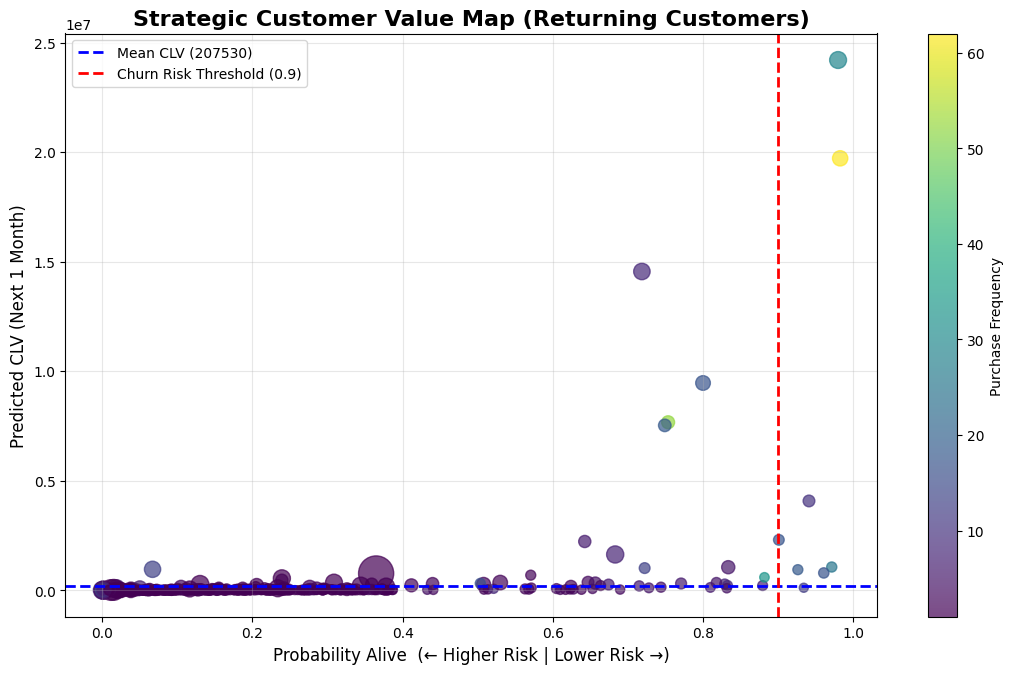

In [67]:
import gc
import matplotlib.pyplot as plt

gc.collect()
plt.close('all')

# Focus on returning customers (frequency > 0)
plot_data = clv_data[clv_data['frequency'] > 0].copy()

x = plot_data['probability_alive']
y = plot_data['CLV_1_month']
colors = plot_data['frequency']

# Bubble size scaled by monetary value
sizes = (
    plot_data['monetary_value'] /
    plot_data['monetary_value'].max()
) * 600 + 40

plt.figure(figsize=(11, 7))

sc = plt.scatter(
    x,
    y,
    c=colors,
    s=sizes,
    cmap='viridis',
    alpha=0.7
)

# Mean CLV reference line
avg_clv = y.mean()
plt.axhline(
    y=avg_clv,
    color='blue',
    linestyle='--',
    linewidth=2,
    label=f'Mean CLV ({avg_clv:.0f})'
)

# Churn risk threshold
plt.axvline(
    x=0.9,
    color='red',
    linestyle='--',
    linewidth=2,
    label='Churn Risk Threshold (0.9)'
)

plt.title(
    'Strategic Customer Value Map (Returning Customers)',
    fontsize=16,
    fontweight='bold'
)
plt.xlabel('Probability Alive  (← Higher Risk | Lower Risk →)', fontsize=12)
plt.ylabel('Predicted CLV (Next 1 Month)', fontsize=12)

cbar = plt.colorbar(sc)
cbar.set_label('Purchase Frequency')

plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
